**Author**: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from typing import Union
import pymc as pm
import arviz as az
import aesara.tensor as at
from ipywidgets import widgets
from IPython.display import display

from hrd_simulation import simulate_hrd

In [3]:
def cumulative_normal(x, alpha, beta):
    """Cumulative distribution function for the standard normal distribution"""
    return 0.5 + 0.5 * at.erf((x - alpha) / (beta * at.sqrt(2)))

# Infering the agent strategy from behaviors

Simulating data

In [31]:
interoceptor_df = simulate_hrd(
    mean_hr=60, 
    std_hr=1,
    mean_interoceptive_accuracy=0.0, 
    std_interoceptive_accuracy=5.0,
    agent="interoceptor",
    n_boot=100
)

## Interoceptors model

In [32]:
# Format data before modelling
n_trials = len(interoceptor_df)
trials_vec = np.arange(0, len(interoceptor_df))
n_total = np.ones(len(interoceptor_df))
responses = interoceptor_df.responses.to_numpy()

In [33]:
with pm.Model() as interoceptive_model:
    
    # Interoceptive noise parameters
    mean_interoceptive_accuracy = pm.Uniform("mean_interoceptive_accuracy", lower=-50.0, upper=50.0)
    std_interoceptive_accuracy = pm.Uniform("std_interoceptive_accuracy", lower=0.1, upper=30.0)
    
    thetaij = pm.Deterministic(
        "thetaij", cumulative_normal(
            interoceptor_df.alphas.to_numpy(), 
            alpha=mean_interoceptive_accuracy, 
            beta=std_interoceptive_accuracy
        )
    )

    rij_ = pm.Binomial("rij", p=thetaij, n=n_total, observed=responses)

In [34]:
with interoceptive_model:
    idata_interoceptive = pm.sample(chains=4, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean_interoceptive_accuracy, std_interoceptive_accuracy]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


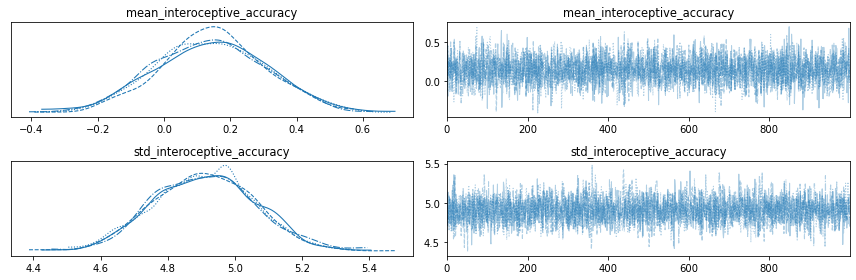

In [35]:
az.plot_trace(idata_interoceptive, var_names=["mean_interoceptive_accuracy", "std_interoceptive_accuracy"])
plt.tight_layout()

## Believers model

In [36]:
with pm.Model() as believing_model:
    
    # Interoceptive noise parameters
    mean_belief = pm.Uniform("mean_belief", lower=20.0, upper=180.0)
    std_belief = pm.Uniform("std_belief", lower=0.1, upper=50.0)
    
    thetaij = pm.Deterministic(
        "thetaij", cumulative_normal(
            interoceptor_df.tones.to_numpy(), 
            alpha=mean_belief, 
            beta=std_belief
        )
    )

    rij_ = pm.Binomial("rij", p=thetaij, n=n_total, observed=responses)

In [37]:
with believing_model:
    idata_believing = pm.sample(chains=4, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mean_belief, std_belief]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


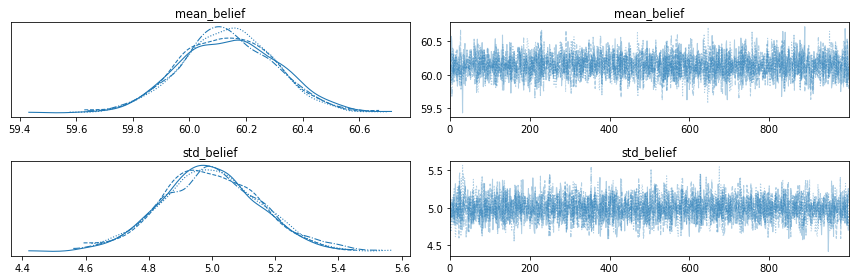

In [38]:
az.plot_trace(idata_believing, var_names=["mean_belief", "std_belief"])
plt.tight_layout()

# Model comparison

In [39]:
pm.compare({"interoceptor": idata_interoceptive, "beliver": idata_believing})

/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
interoception,0,-891.216961,1.961608,0.000000,0.974353,32.556515,0.000000,True,log
beliver,1,-906.372596,1.965084,15.155636,0.025647,32.835046,5.663106,True,log
